In [1]:
# You can run this block to set up your environment. You don't need to run this block if you have already
# finished your environment set up
!pip install nltk
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install tensorflow

  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 20.1 MB/s eta 0:00:00
Using cached click-8.1.8-py3-none-any.whl (98 kB)
  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-an

## Data Loader

Python provides a lot of packages to load files in different formats. We provide a simple data loader to help you load .csv files.

In [8]:
import pandas as pd

def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df['id'], df["text"], df['label']

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)['label']

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "label"]
    df.to_csv(file_name, index=False)

## Feature Extractor


The **feature extractor** is one of the most important parts in a pipeline.
In this tutorial, we introduce four different functions to extract features.


In [9]:
import nltk
nltk.download('punkt_tab')

def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\chuny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Given a sentence. *'Text mining is to identify useful information.'*, this function is used to tokenize it to a list of tokens.

In [10]:
tokens = tokenize("Text mining is to identify useful information.")
print(tokens)

['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']


Here we simply treat each word as a feature. Assume we get all features, the next step is to make these features suitable for the following models.
One simple and common way is to use the one-hot vector (maybe it is not the best solution).

In [11]:
import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

In [12]:
print(get_onehot_vector(tokens, {"Text": 0, "mining": 1, "COMP": 2, "HKUST": 3}))

[1. 1. 0. 0.]


In this example, "text" and "mine" appears in the tokens but "COMP" and "HKUST" not. So the 0 th, 1 th elements are ones and other elements are ones.

## Classifier

### Single Layer Perceptron

We introduce a 1-layer perceptron to classify reviews. This perceptron includes 1 dense layer with the softmax activation.
Keras is the easiest deep learning framework so that we choose it to build this network.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


def build_SLP(input_size, output_size, learning_rate=0.1):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param learning_rate: the learning rate for SGD
    return a 1-layer perceptron,
    """
    model = Sequential()
    
    # add 1 layer with softmax activation
    # you should specify the output size, the input_size, and the activation function
    model.add(Dense(output_size, activation="softmax", input_dim=input_size))
    
    # set the loss as categorical_crossentropy, the metric as accuracy, and the optimizer as SGD
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=learning_rate), metrics=['accuracy'])
    
    return model

### Multi Layer Perceptron

One vital change in multi-layer perceptron is the number of layers. We stack more layers so that extracted features can be further enhanced in hidden layers.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, LayerNormalization
import tensorflow.keras as K

def build_MLP(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: float
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return: a multi-layer perceptron
    """
    model = Sequential()

    if num_layers == 1:
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=input_size,
                        kernel_initializer=K.initializers.he_normal(seed=0),
                        bias_initializer="zeros",
                        kernel_regularizer=K.regularizers.l2(l2_reg)))
    else:
        for i in range(num_layers - 1):
            if i == 0:
                # first layer: input -> hidden
                model.add(Dense(hidden_size,
                                input_dim=input_size,
                                kernel_initializer=K.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=K.regularizers.l2(l2_reg)))
            else:
                # hidden layers: hidden -> hidden
                model.add(Dense(hidden_size,
                                kernel_initializer=K.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=K.regularizers.l2(l2_reg)))

            # add layer_norm
            if layer_norm:
                model.add(LayerNormalization())
            # add batch_norm
            if batch_norm:
                model.add(BatchNormalization())
            # add activation
            model.add(Activation(activation))
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                model.add(Dropout(dropout_rate, seed=0))

        # last layer: hidden -> class
        model.add(Dense(output_size,
                        activation="softmax",
                        kernel_initializer=K.initializers.he_normal(seed=0),
                        bias_initializer="zeros"))

    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = K.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optimizer = K.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optimizer = K.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError("Optimizer not implemented.")
    
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

### Connect All Parts

Now we have the data loader, feature extractor, and the classifier. We can connect them to finish this pipeline of classification.

In [15]:
train_file = "data/train.csv"
test_file = "data/test.csv"
ans_file = "data/ans.csv"
pred_file = "data/pred.csv"

# load data
train_ids, train_texts, train_labels = load_data(train_file)
test_ids, test_texts, _ = load_data(test_file)
test_labels = load_labels(ans_file)

# extract features

# tokenization
# the input is the text and the output is the word list
train_tokens = [tokenize(text) for text in train_texts]
test_tokens = [tokenize(text) for text in test_texts]


# build the feature list
train_feats = list()
for i in range(len(train_ids)):
    # concatenate the stemmed token list and the 2_gram list together
    train_feats.append(train_tokens[i])
test_feats = list()
for i in range(len(test_ids)):
    # concatenate the stemmed token list and the 2_gram list together
    test_feats.append(test_tokens[i])

# build the feature dict
feats = set()
# collect all features
for f in train_feats:
    feats.update(f)
print("Size of features:", len(feats))
# build a mapping from features to indices
feats_dict = dict(zip(feats, range(len(feats))))

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack([get_onehot_vector(f, feats_dict) for f in train_feats])
test_feats_matrix = np.vstack([get_onehot_vector(f, feats_dict) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = tf.keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = tf.keras.utils.to_categorical(test_labels-1, num_classes=num_classes)


Size of features: 16202


In [16]:
# build the classifier

model_SLP = build_SLP(len(feats_dict), num_classes, learning_rate=0.1)

model_MLP = build_MLP(len(feats_dict), num_classes, 3, 64, learning_rate=0.1)

c:\Users\chuny\anaconda3\envs\comp4332\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Splite Validation Set and Train the model

When we do not know the test performance, it is not easy to check when the classifier is good enough. Hence, we set the epochs manually (e.g. total_epoch = 10).
If we have a validation set, we can use the validation performance to find the best classifier during the training.

In [17]:
print(train_feats_matrix.shape, train_label_matrix.shape)

(2000, 16202) (2000, 5)


In [18]:
from sklearn.model_selection import train_test_split
train_feats_matrix, val_feats_matrix, train_label_matrix, val_label_matrix = train_test_split(
    train_feats_matrix, train_label_matrix, test_size=0.1, random_state=42
)

# training
history_SLP = model_SLP.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(val_feats_matrix, val_label_matrix),
                    epochs=40, batch_size=100)

history_MLP = model_MLP.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(val_feats_matrix, val_label_matrix),
                    epochs=40, batch_size=100)


Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4240 - loss: 1.4633 - val_accuracy: 0.5000 - val_loss: 1.3472
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4954 - loss: 1.2713 - val_accuracy: 0.4850 - val_loss: 1.2585
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5182 - loss: 1.1813 - val_accuracy: 0.5100 - val_loss: 1.2087
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5681 - loss: 1.0777 - val_accuracy: 0.5150 - val_loss: 1.1719
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6131 - loss: 1.0142 - val_accuracy: 0.5400 - val_loss: 1.1502
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6454 - loss: 0.9745 - val_accuracy: 0.5200 - val_loss: 1.1257
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6482 - loss: 0.9434 - val_accuracy: 0.5500 - val_loss: 1.1055
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6858 - loss: 0.9072 - val_accuracy: 0.5650 - val_loss

Let's try this pipeline for test data!

In [19]:
# evaluation
train_score = model_SLP.evaluate(train_feats_matrix, train_label_matrix, batch_size=100)
val_score = model_SLP.evaluate(val_feats_matrix, val_label_matrix, batch_size=100)
test_score = model_SLP.evaluate(test_feats_matrix, test_label_matrix, batch_size=100)
print("SLP training loss:", train_score[0], "training accuracy", train_score[1])
print("SLP validating loss:", val_score[0], "validating accuracy", val_score[1])
print("SLP test loss:", test_score[0], "test accuracy", test_score[1])

train_score = model_MLP.evaluate(train_feats_matrix, train_label_matrix, batch_size=100)
val_score = model_MLP.evaluate(val_feats_matrix, val_label_matrix, batch_size=100)
test_score = model_MLP.evaluate(test_feats_matrix, test_label_matrix, batch_size=100)
print("MLP training loss:", train_score[0], "training accuracy", train_score[1])
print("MLP validating loss:", val_score[0], "validating accuracy", val_score[1])
print("MLP test loss:", test_score[0], "test accuracy", test_score[1])

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9030 - loss: 0.4424 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6167 - loss: 0.9840
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5373 - loss: 1.1491 
SLP training loss: 0.44703105092048645 training accuracy 0.902222216129303
SLP validating loss: 0.9620640277862549 validating accuracy 0.6150000095367432
SLP test loss: 1.1345309019088745 test accuracy 0.5375000238418579
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6000 - loss: 1.4306
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5250 - loss: 2.1452
MLP training loss: 0.011181512847542763 training accuracy 1.0
MLP validating loss: 1.3989073038101196 validating accuracy 0.6100000143051147
MLP test loss: 2.065852165222168 test accuracy 0.5274999737739563


You can try different hyperparameters by yourselves.

However, our classifier here is overfitted. The training loss is much smaller than the test loss.
Later we will introduce more strategies to make classifiers better generalized.

In [20]:
# save predictions
# test_pred = model.predict_classes(test_feats_matrix)
test_pred = np.argmax(model_MLP.predict(test_feats_matrix), axis=-1)
write_predictions(pred_file, test_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


### Visualization

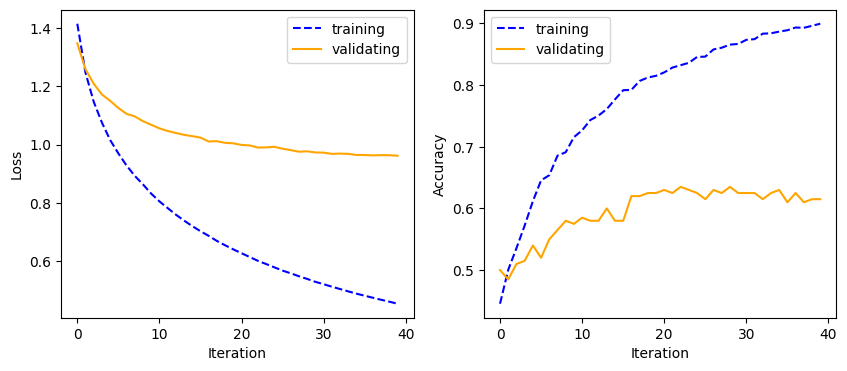

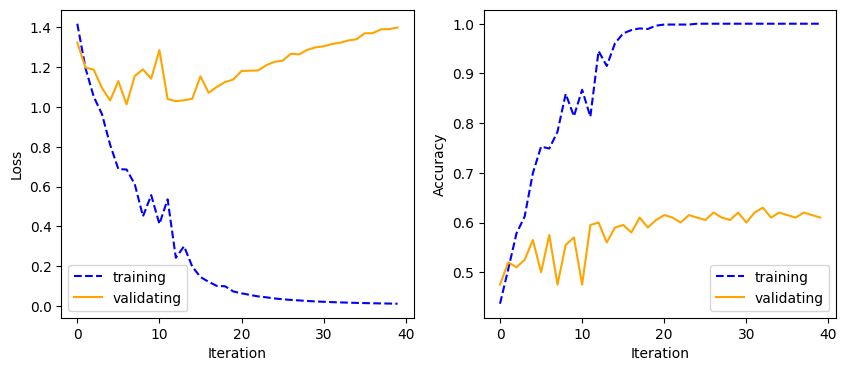

In [21]:
import matplotlib.pyplot as plt

for history in [history_SLP, history_MLP]:
    ''' Plot loss-iteration '''
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
    plt.plot(history.history["val_loss"], label="validating", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    ''' Plot accuracy-iteration '''
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="training", color="blue", linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="validating", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()